In [10]:
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from utils.functions import plot_clusters_2d
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from utils.functions import evaluate_clusters


# Function to process and pivot each dataframe
def rename_df_col(df, col_name):
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna("Not Available", inplace=True)
    
    df_filtered = df[['Location', 'Period', 'Value']]
    df_renamed = df_filtered.rename(columns={'Value': col_name})
    print(df_renamed.columns)
    return df_renamed

# Load the datasets
advertisingBan = pd.read_csv('../data/advertising_ban_internet.csv')
affordability = pd.read_csv('../data/affordability.csv')
gdp2000Cigs = pd.read_csv('../data/gdp_for_2000_cigs.csv')
healthWarningPhoto = pd.read_csv('../data/health_warning_photo.csv')
requiredHealthWarnings = pd.read_csv('../data/required_health_warning.csv')

# Process and pivot each dataframe
advertisingBan = rename_df_col(advertisingBan, 'advertisingBan')
affordability = rename_df_col(affordability, 'affordability')
#ageStandardized = rename_df_col(ageStandardized, 'ageStandardized')
gdp2000Cigs = rename_df_col(gdp2000Cigs, 'gdp2000Cigs')
healthWarningPhoto = rename_df_col(healthWarningPhoto, 'healthWarningPhoto')
requiredHealthWarnings = rename_df_col(requiredHealthWarnings, 'requiredHealthWarnings')

Index(['Location', 'Period', 'advertisingBan'], dtype='object')
Index(['Location', 'Period', 'affordability'], dtype='object')
Index(['Location', 'Period', 'gdp2000Cigs'], dtype='object')
Index(['Location', 'Period', 'healthWarningPhoto'], dtype='object')
Index(['Location', 'Period', 'requiredHealthWarnings'], dtype='object')


C:\Users\albin\AppData\Local\Temp\ipykernel_12268\2101676913.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Available' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Not Available", inplace=True)
C:\Users\albin\AppData\Local\Temp\ipykernel_12268\2101676913.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Available' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Not Available", inplace=True)
C:\Users\albin\AppData\Local\Temp\ipykernel_12268\2101676913.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Available' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna

In [12]:

# Merge the pivoted dataframes on 'Location'
combined_df = advertisingBan.merge(affordability, on=['Location','Period'], how='outer')
combined_df = combined_df.merge(gdp2000Cigs, on=['Location','Period'], how='outer')
combined_df = combined_df.merge(healthWarningPhoto, on=['Location','Period'], how='outer')
combined_df = combined_df.merge(requiredHealthWarnings, on=['Location','Period'], how='outer')
combined_df

,Location,Period,advertisingBan,affordability,gdp2000Cigs,healthWarningPhoto,requiredHealthWarnings
0,Afghanistan,2007,No,NaN,NaN,Not applicable,No
1,Afghanistan,2008,No,NaN,NaN,Not applicable,No
2,Afghanistan,2010,No,NaN,NaN,Not applicable,No
3,Afghanistan,2012,No,3.75,3.75,Not applicable,No
4,Afghanistan,2014,No,4.67,4.67,Not applicable,No
...,...,...,...,...,...,...,...
1750,"occupied Palestinian territory, including east...",2014,Yes,18.34,18.34,No,Yes
1751,"occupied Palestinian territory, including east...",2016,Yes,16.24,16.24,No,Yes
1752,"occupied Palestinian territory, including east...",2018,Yes,17.20,17.20,No,Yes
1753,"occupied Palestinian territory, including east...",2020,Yes,19.76,19.76,No,Yes


In [13]:
# Pre-cleansed
print('Pre-cleanse: ', len(combined_df))

combined_df = combined_df.replace({'Not applicable': 'No'})
combined_fg = combined_df.dropna()
print('Post-cleanse:', len(combined_fg))
combined_df = combined_fg.sort_values('Period')

Pre-cleanse:  1755
Post-cleanse: 1170


In [18]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop 'Location' for clustering
data_for_clustering = combined_df.drop(columns=['Location'])

# Fix the typo in `astpye` and convert 'Period' to datetime
data_for_clustering['Period'] = pd.to_datetime(data_for_clustering['Period'])

# Preprocessing pipeline: imputing, encoding, and scaling
numeric_features = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_for_clustering.select_dtypes(include=['object']).columns

# Define the numeric transformer pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define the categorical transformer pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the numeric and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Check columns to ensure 'Period' exists before setting it as index
print(data_for_clustering.columns)

# Set 'Period' as index, which should be excluded from clustering
reindexed_df = data_for_clustering.set_index('Period')

# Prepare the final data for clustering
clustering_data = preprocessor.fit_transform(reindexed_df)

Index(['Period', 'advertisingBan', 'affordability', 'gdp2000Cigs',
       'healthWarningPhoto', 'requiredHealthWarnings'],
      dtype='object')


In [40]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

X = to_time_series_dataset(clustering_data)
result = pd.DataFrame(columns=['k', 'silhouette' ,'davies_bouldin'])

K = np.arange(5, 36, 5)

for k in K:
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='dtw')
    kmeans.fit(clustering_data)
    mask = kmeans.labels_ != -1
    data = clustering_data[mask]
    labels = kmeans.labels_[mask]

    silhouette = evaluate_clusters(silhouette_score, data, labels)
    davies_bouldin = evaluate_clusters(davies_bouldin_score, data, labels)
    
    result.loc[len(result)] = [k, silhouette, davies_bouldin]
    


silhouette_score: 0.32322598797416835
davies_bouldin_score: 1.014918638947363
silhouette_score: 0.4439556651501836
davies_bouldin_score: 1.1391790705099372


KeyboardInterrupt: 

Text(0, 0.5, 'score')

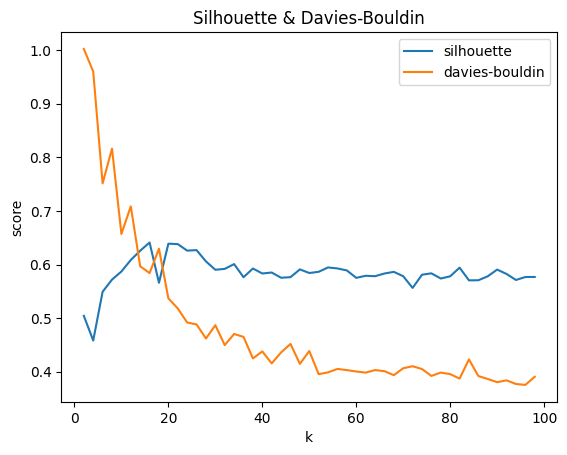

In [16]:
import matplotlib.pyplot as plt
k_sort = result.sort_values('k', ascending=True)
plt.plot(k_sort['k'], k_sort['silhouette'])
plt.plot(k_sort['k'], k_sort['davies_bouldin'])
plt.legend(['silhouette', 'davies-bouldin'])
plt.title('Silhouette & Davies-Bouldin')
plt.xlabel('k')
plt.ylabel('score')

## k=20 looks ok, highest silhouette, 'low' davies-bouldin

In [38]:
X = to_time_series_dataset(clustering_data)

(1755, 8, 1)

In [ ]:

kmeans = TimeSeriesKMeans(n_clusters=20, metric='dtw')
kmeans.fit(X)
silhouette = evaluate_clusters(silhouette_score, data, labels)
davies_bouldin = evaluate_clusters(davies_bouldin_score, data, labels)

In [34]:
#plot_clusters_2d(kmeans, X, reindexed_df)